In [1]:
%load_ext autoreload
%autoreload 2

# Functions & Imports

In [2]:
from Setup.config import config
import os
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from Tools.leica_tools import RawLoader
from Tools.db_tools import DbManager
from functools import partial
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.optimizers import Adam, RMSprop
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Layer
from keras.losses import MeanSquaredError, CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.utils import plot_model

# Cell count classification

In [3]:
def cell_count(inputs, cls_label):
    # Add convolutional layer
    conv1 = Conv2D(32, (3, 3), activation='relu', name=cls_label + '_conv1')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), name=cls_label + '_pool1')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', name=cls_label + '_conv2')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), name=cls_label + '_pool2')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', name=cls_label + '_conv3')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2), name=cls_label + '_pool3')(conv3)

    # Flatten the output from the convolutional layers
    flatten = Flatten(name=cls_label + '_flatten')(pool3)

    # Add fully connected layers
    dense1 = Dense(512, activation='relu', name=cls_label + '_dense1')(flatten)
    dropout1 = Dropout(0.5, name=cls_label + '_dropout1')(dense1)  # Dropout rate of 0.5 (50% dropout rate)

    dense2 = Dense(256, activation='relu', name=cls_label + '_dense2')(dropout1)
    dropout2 = Dropout(0.5, name=cls_label + '_dropout2')(dense2)  # Dropout rate of 0.5 (50% dropout rate)

    dense3 = Dense(128, activation='relu', name=cls_label + '_dense3')(dropout2)
    dropout3 = Dropout(0.5, name=cls_label + '_dropout3')(dense3)  # Dropout rate of 0.5 (50% dropout rate)

    output = Dense(5, activation='softmax', name=cls_label + '_output')(dropout3)

    model = Model(inputs=inputs, outputs=output, name=cls_label + '_model')

    return model

def get_model(labels):
    input = Input(shape=(128,128,4), name='cell_count_input')
    models = [cell_count(input, label) for label in labels]
    model = Model(inputs=[input], outputs=[m.output for m in models])
    model.compile(optimizer=Adam(),
                  loss={label+'_output': CategoricalCrossentropy() for label in labels},
                  metrics={label+'_output': CategoricalAccuracy() for label in labels})
    return model

def get_single_model(label):
    input = Input(shape=(128,128,4), name='cell_count_input')
    model = cell_count(input, label)
    model.compile(optimizer=Adam(),
                  loss = {f'{label}_output': CategoricalCrossentropy()},
                  metrics= {f'{label}_output': CategoricalAccuracy()})
    return model

In [4]:
def filter_dataset(element, filter_df):
    return tf.py_function(lambda x, i: filter_df.loc[(x.numpy().decode(), i.numpy()), 'include'], [element['expID'], element['GlobalID']], tf.bool)
    
def prepare_data(element, annotations):
    globalID = element['GlobalID']  # Assuming 'GlobalID' is a tensor
    image = tf.cast(element['frame'], tf.float32)
    image = tf.math.log(image+1)
    image = (image - tf.reduce_min(image)) /(tf.reduce_max(image) - tf.reduce_min(image))
    element['cell_count_input'] = image
    
    outputs = {}
    for ann_key in annotations.columns:
        label = tf.py_function(lambda x, i: annotations.loc[(x.numpy().decode(), i.numpy()), ann_key], [element['expID'], globalID], tf.int64)
        label.set_shape(())
        label = tf.cast(tf.one_hot(label, 5), tf.int64)
        outputs[ann_key + '_output'] = label
    return element, outputs
    
def build_dataset(expIDs, annotation_keys):
    dataset = dbm.get_datasets(expIDs, shuffle=True)
    filter_dfs = []
    ann_dfs = []
    for expID in expIDs:
        drop_register = RawLoader(expID).get_dropregister()
        ann_df = dbm.get_wps(expID, allow_partial=False).set_index('GlobalID').filter(annotation_keys)
        ann_df = ann_df[ann_df.apply(lambda row: (row != 10).all(), axis=1)].copy()
        ann_df[ann_df > 4] = 4
        

        filter_df = pd.Series({ID: (ID in ann_df.index) for ID in drop_register.index}, name='include').to_frame()
        filter_df.set_index(pd.MultiIndex.from_product([[expID], filter_df.index]), inplace=True)
        filter_dfs.append(filter_df)
        
        ann_df.set_index(pd.MultiIndex.from_product([[expID], ann_df.index]), inplace=True)
        ann_dfs.append(ann_df)
    filter_df = pd.concat(filter_dfs)
    ann_df = pd.concat(ann_dfs)
    
    filtered_dataset = dataset.filter(partial(filter_dataset, filter_df=filter_df))
    annotated_dataset = filtered_dataset.map(partial(prepare_data, annotations=ann_df))
    return annotated_dataset
    
    

In [5]:
dbm = DbManager()

In [21]:
expIDs = ['NKIP_FA_052', 'NKIP_FA_055', 'NKIP_FA_056', 'FA_2024_049', 'FA_2024_050', 'AT_2024_007', ]
annotation_keys = ['Target', 'Effector', 'dead_Target', 'dead_Effector']
dataset = build_dataset(expIDs, annotation_keys)
validation_dataset = build_dataset(['NKIP_FA_053'], annotation_keys)

In [22]:
n_elements = dataset.reduce(tf.constant(0), lambda a,b: a+1).numpy()
n_elements_val = validation_dataset.reduce(tf.constant(0), lambda a,b: a+1).numpy()
print(f'{n_elements} frames in train dataset')
print(f'{n_elements_val} frames in test dataset')

11050 frames in train dataset
958 frames in test dataset


In [23]:
train_final = dataset.repeat(12).batch(32)
test_final = validation_dataset.repeat(12).batch(32)

In [24]:
model = get_model(annotation_keys)

In [25]:
model_arch = plot_model(model, to_file='cell_count.png', dpi=100)

In [26]:
model.fit(train_final, validation_data=test_final, batch_size=32, steps_per_epoch=375, epochs=12, validation_steps=29)

Epoch 1/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 265s 699ms/step - Effector_output_categorical_accuracy: 0.5740 - Target_output_categorical_accuracy: 0.4686 - dead_Effector_output_categorical_accuracy: 0.8161 - dead_Target_output_categorical_accuracy: 0.7177 - loss: 3.7179 - val_Effector_output_categorical_accuracy: 0.7812 - val_Target_output_categorical_accuracy: 0.8470 - val_dead_Effector_output_categorical_accuracy: 0.9289 - val_dead_Target_output_categorical_accuracy: 0.9472 - val_loss: 1.4597
Epoch 2/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 257s 687ms/step - Effector_output_categorical_accuracy: 0.7441 - Target_output_categorical_accuracy: 0.7312 - dead_Effector_output_categorical_accuracy: 0.8527 - dead_Target_output_categorical_accuracy: 0.8286 - loss: 2.1251 - val_Effector_output_categorical_accuracy: 0.8685 - val_Target_output_categorical_accuracy: 0.8190 - val_dead_Effector_output_categorical_accuracy: 0.9461 - val_dead_Target_output_categorical_accuracy: 0.9450 - val_loss: 1.2456
Epoch 3/12
3

2024-07-18 18:43:13.471939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/fauberma/mambaforge/envs/dropcnn/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - Effector_output_categorical_accuracy: 0.8508 - Target_output_categorical_accuracy: 0.9070 - dead_Effector_output_categorical_accuracy: 0.9007 - dead_Target_output_categorical_accuracy: 0.9074 - loss: 1.1625 - val_Effector_output_categorical_accuracy: 0.8944 - val_Target_output_categorical_accuracy: 0.9170 - val_dead_Effector_output_categorical_accuracy: 0.9149 - val_dead_Target_output_categorical_accuracy: 0.9601 - val_loss: 0.9750


In [12]:
model.save(os.path.join(os.getenv('MODEL_DIR'), 'cell_count_v2.h5'))

# Evaluate performance

In [19]:
dbm = DbManager()
expIDs = [ 'NKIP_FA_052', 'NKIP_FA_055', 'NKIP_FA_056', 'FA_2024_049', 'FA_2024_050', 'AT_2024_007',]
annotation_keys = ['Target', 'Effector', 'dead_Target', 'dead_Effector']
dataset = build_dataset(expIDs, annotation_keys)

In [20]:
model = load_model(os.path.join(os.getenv('MODEL_DIR'), 'cell_count_v2.h5'))
predictions = model.predict(dataset.batch(32))
y_pred = pd.DataFrame(np.argmax(np.array(predictions), axis=-1).transpose(), columns=annotation_keys)

y_true = y_pred.copy()
for i, (element, output) in enumerate(dataset.as_numpy_iterator()):
    y_true.iloc[i, :] = np.array([np.argmax(output[f'{key}_output']) for key in annotation_keys])

     10/Unknown 4s 412ms/step

KeyboardInterrupt: 

Text(0.5, 0, 'Predicted number of cells')

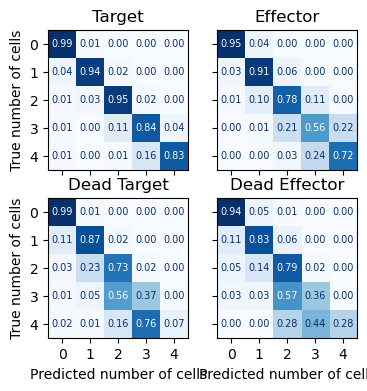

In [18]:
ann2title = {'Target': 'Target',
             'Effector': 'Effector',
             'dead_Target': 'Dead Target',
             'dead_Effector': 'Dead Effector'}

fig,axs = plt.subplots(ncols=2, nrows=2, figsize=(4,4), dpi=100, sharey=True, sharex=True)
for ax, ann in zip(axs.flatten(), annotation_keys):
    ConfusionMatrixDisplay.from_predictions(y_true=y_true[ann], y_pred=y_pred[ann], labels=np.arange(5),cmap='Blues',ax=ax,colorbar=False, normalize='true', values_format='.2f', text_kw={'fontsize': 7})
    ax.grid(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(ann2title[ann])

axs.flatten()[0].set_ylabel('True number of cells')
axs.flatten()[2].set_ylabel('True number of cells')
axs.flatten()[2].set_xlabel('Predicted number of cells')
axs.flatten()[3].set_xlabel('Predicted number of cells')